In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
import torch
import yaml
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer, geo_name
from scalar_features import ScalarFeaturizer, scalar_name
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils
import feature_importance

/ext3/miniconda3/envs/eqenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Parameter setup

Plotting

In [2]:
inferno_r = matplotlib.cm.inferno_r
cmap_hist = utils.shiftedColorMap(inferno_r, start=0.1, stop=1.0)

Saving

In [3]:
plot_dir = '../plots/2023-05-04_figures'
save = True

## Load data

In [4]:
sim_name = 'TNG100-1'
sim_name_dark = f'{sim_name}-Dark'

halo_tag = ''
select_tag = ''

In [5]:
fn_select_config = f'../configs/halo_selection_{sim_name}{halo_tag}.yaml'
with open(fn_select_config, 'r') as file:
    select_params = yaml.safe_load(file)
tab_select = utils.load_table(select_params['select']['fn_select'])
print("N_select:", len(tab_select))

N_select: 31413


In [6]:
fn_halo_config = select_params['halo']['fn_halo_config']
with open(fn_halo_config, 'r') as file:
    halo_params = yaml.safe_load(file)
tab_halos = utils.load_table(halo_params['halo']['fn_halos'])

In [7]:
sp = halo_params['sim']
sim_reader = SimulationReader(sp['base_dir'], sp['sim_name'], 
                              sp['sim_name_dark'], sp['snap_num_str'])

In [8]:
mass_multiplier = sim_reader.mass_multiplier
log_mass_shift = sim_reader.log_mass_shift

In [9]:
idxs_table = np.array(tab_select['idx_table'])

In [10]:
tab_halos_select = tab_halos[idxs_table]
print(len(tab_halos_select))

31413


In [11]:
frac_train, frac_val, frac_test = 0.7, 0.15, 0.15
random_ints = tab_select['rand_int']
idx_train, idx_valid, idx_test = utils.split_train_val_test(random_ints, 
                    frac_train=frac_train, frac_val=frac_val, frac_test=frac_test)

In [12]:
log_m200m = tab_halos['log_m200m_fof'][idxs_table]

Text(0, 0.5, 'number per bin')

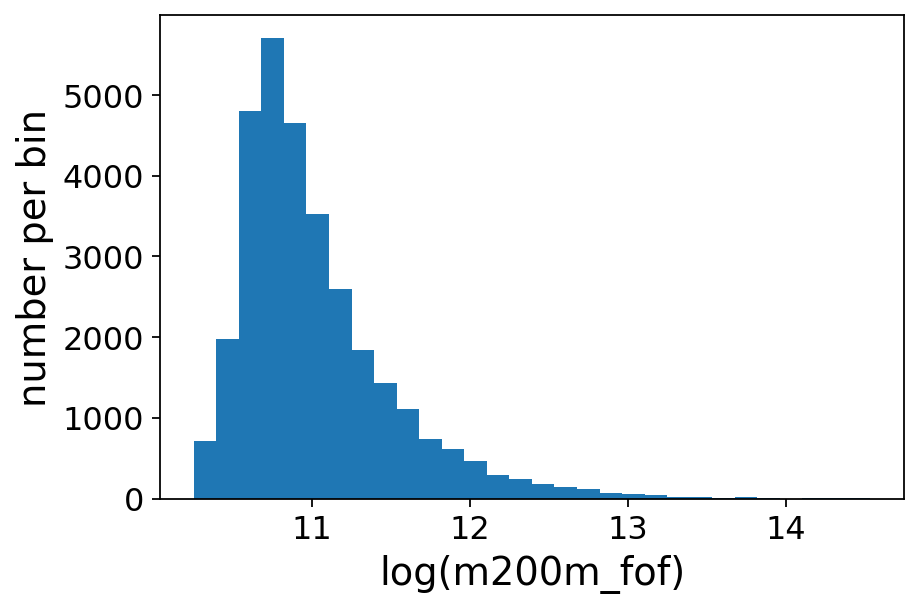

In [13]:
plt.hist(log_m200m, bins=30)
plt.xlabel('log(m200m_fof)')
plt.ylabel('number per bin')

In [14]:
tab_halos.columns

<TableColumns names=('idx_halo_dark','idx_subhalo_dark','idx_subhalo_hydro','idx_halo_hydro','m200m','r200m','v200m','x_com','x_grouppos','x_minPE','spin_subhalo','mstellar','rstellar','mgas','mbh','mbh_per_mstellar','sfr','sfr1','gband','gband_minus_iband','jstellar','m200m_hydro','npartstellar','npartgas','m200m_fof','r200m_fof','v200m_fof','m200m_fof_rmax','r200m_fof_rmax','v200m_fof_rmax','log_m200m','log_m200m_fof','log_m200m_hydro','log_mstellar','log_mgas','log_mbh','log_mbh_per_mstellar','log_rstellar','log_r200m','log_jstellar','log_ssfr','log_ssfr1','m200c','veldisp_subhalo','c200c','a_form','log_M200c_Msun_structure')>

#### colorbar normalization

In [15]:
frac_test = len(idx_test)/len(tab_select)
L_Mpc = sim_reader.box_size / 1000.0
weight = 1/(L_Mpc**3 * frac_test)
colorbar_label = 'galaxy number density'#+r'[$h^{-1}$ Mpc)$^{-3}$ dex$^{-2}$]'

#### fiducial model tag

In [16]:
model_tag = '_hgboost_yerrnan_epochs300_lr0.1'

# M stellar

In [17]:
x_label_name = 'log_m200m_fof'
y_label_name = 'log_mstellar'
fit_tag = f'_scalars_n3_{y_label_name}_hgboost_yerrnan_epochs300_lr0.1'
fn_model = f'../models/model_{sim_name}{halo_tag}{fit_tag}.pt'
fn_pred = f'../predictions/predictions_{sim_name}{halo_tag}{fit_tag}.npy'

In [18]:
x_property = tab_halos_select[x_label_name][idx_test]

In [19]:
y_pred = np.load(fn_pred).ravel()

In [20]:
y = utils.load_labels([y_label_name], tab_halos, tab_select).ravel()
y_test = y[idx_test]

error_nn, _ = utils.compute_error(y_test, y_pred, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:285: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


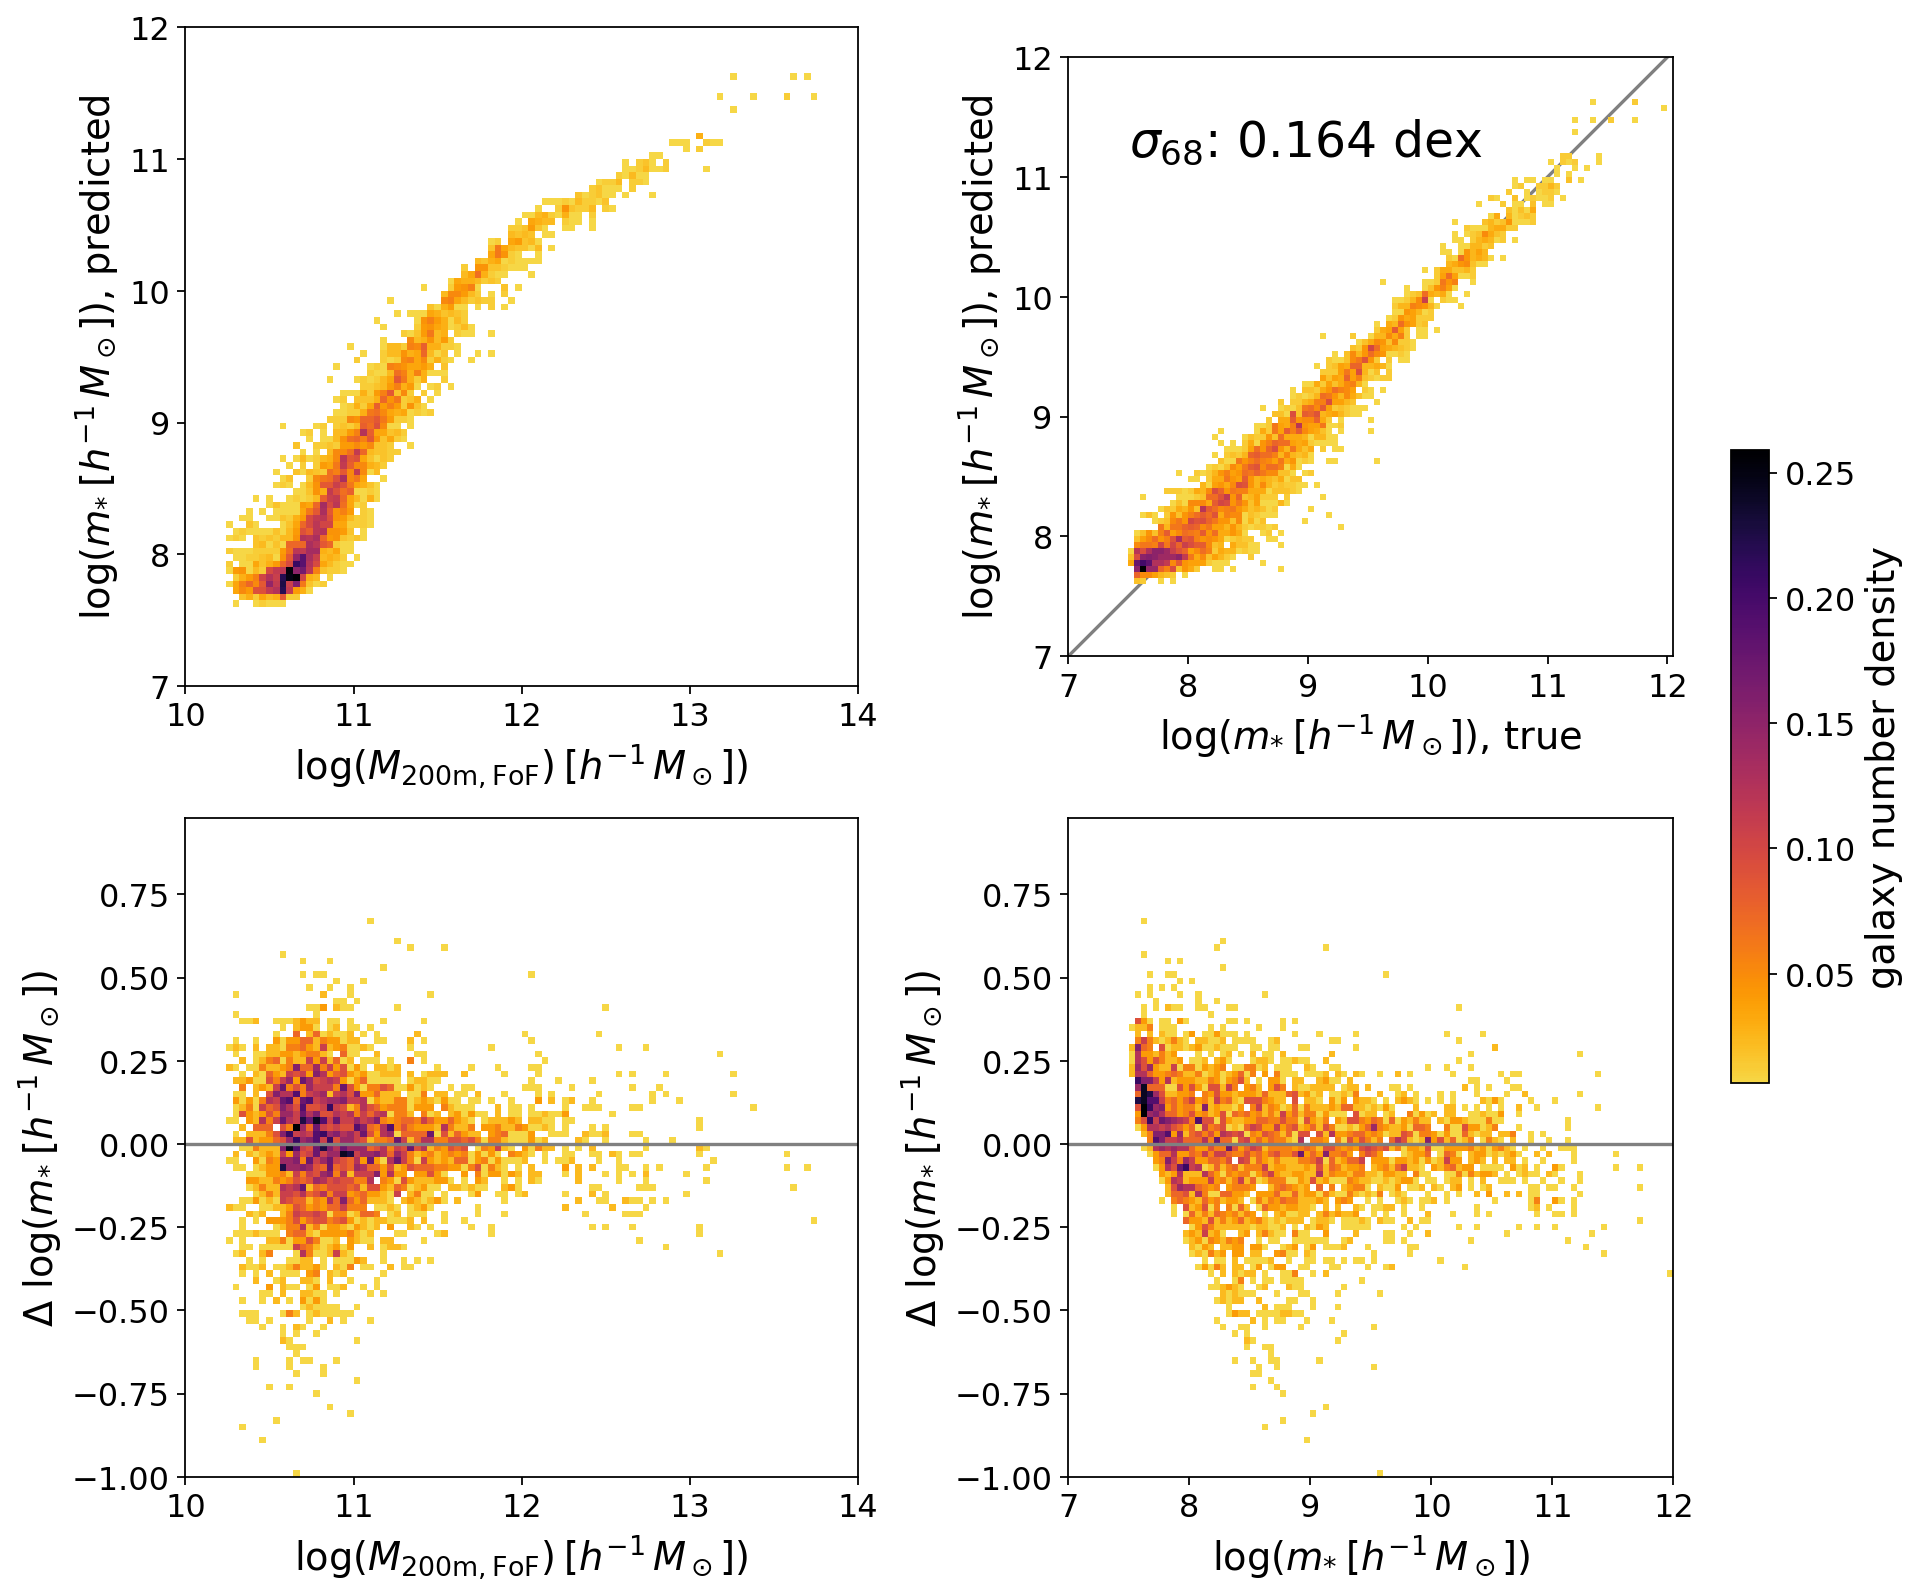

In [21]:
plotter.plot_multi_panel_pred(x_label_name, y_label_name, x_property, y_test, y_pred, 
                              weight=weight, weight_by_dex=True, colorbar_label=colorbar_label,
                              text_results=error_str)
fn = f'{plot_dir}/pred_mstellar.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

# Feature plots for Mstellar

In [22]:
y_label_name = 'log_mstellar'
y = utils.load_labels([y_label_name], tab_halos, tab_select).ravel()
y_test = y[idx_test]

feature_modes = ['scalars_n3', 'geos_n3', 'catalogz0', 'mrv']
#feature_modes = ['scalars', 'geos', 'catalog_z0']

In [23]:
feature_label_dict = {'scalars_n3': 'Invariant scalar features',
                      'geos_n3': 'Geometric features',
                      'catalogz0': 'Standard halo features',
                      'mrv': r'$M_\mathrm{200m,FoF}, R_\mathrm{200m}, V_\mathrm{200m,FoF}$'}
feature_labels = [feature_label_dict[feature_mode] for feature_mode in feature_modes]
print(feature_labels)

['Invariant scalar features', 'Geometric features', 'Standard halo features', '$M_\\mathrm{200m,FoF}, R_\\mathrm{200m}, V_\\mathrm{200m,FoF}$']


In [24]:
y_pred_arr = []
text_results_arr = []
for i, feature_mode in enumerate(feature_modes):

    fit_tag = f'_{feature_mode}_{y_label_name}{model_tag}'

    fn_pred = f'../predictions/predictions_{sim_name}{halo_tag}{fit_tag}.npy'
    y_pred = np.load(fn_pred).ravel()
    
    y_pred_arr.append(y_pred)
    
    error_nn, _ = utils.compute_error(y_test, y_pred, test_error_type='percentile')
    error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
    text_results_arr.append(error_str)

In [25]:
def plot_multi_panel_pred_vs_true(n_rows, n_cols, y_label_name, y_true, y_pred_arr, cmap,
                                  text_results_arr=None, title_arr=None, save_fn=None,
                                  colors_test=None,
                                  weight=1, weight_by_dex=False,
                                  colorbar_label=''):
    fig, axarr = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12,12),
                              #gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [10, 9]},
                              )
    plt.subplots_adjust(hspace=0.4, wspace=0.33)
    
    inferno_r = matplotlib.cm.inferno_r
    cmap = utils.shiftedColorMap(inferno_r, start=0.1, stop=1.0)
    
    count = 0
    for i in range(n_rows):
        for j in range(n_cols):
            #axarr[i,j].set_title(title_arr[count])
            axarr[i,j].set_title('hi!')
            
            h = plotter.plot_pred_vs_true_hist(axarr[i,j], y_label_name, y_true, y_pred_arr[count], cmap, 
                                       text_results=text_results_arr[count],
                                       weight=weight, weight_by_dex=weight_by_dex,
                                              title=title_arr[count])
            count += 1
    
    #ticks = np.arange(5, 25, 5)
    cax = fig.add_axes([0.93, 0.33, 0.02, 0.33])
    cbar = plt.colorbar(h[3], cax=cax, label=colorbar_label)#, ticks=ticks)
    #cbar.ax.set_yticklabels(ticks)


/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:285: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


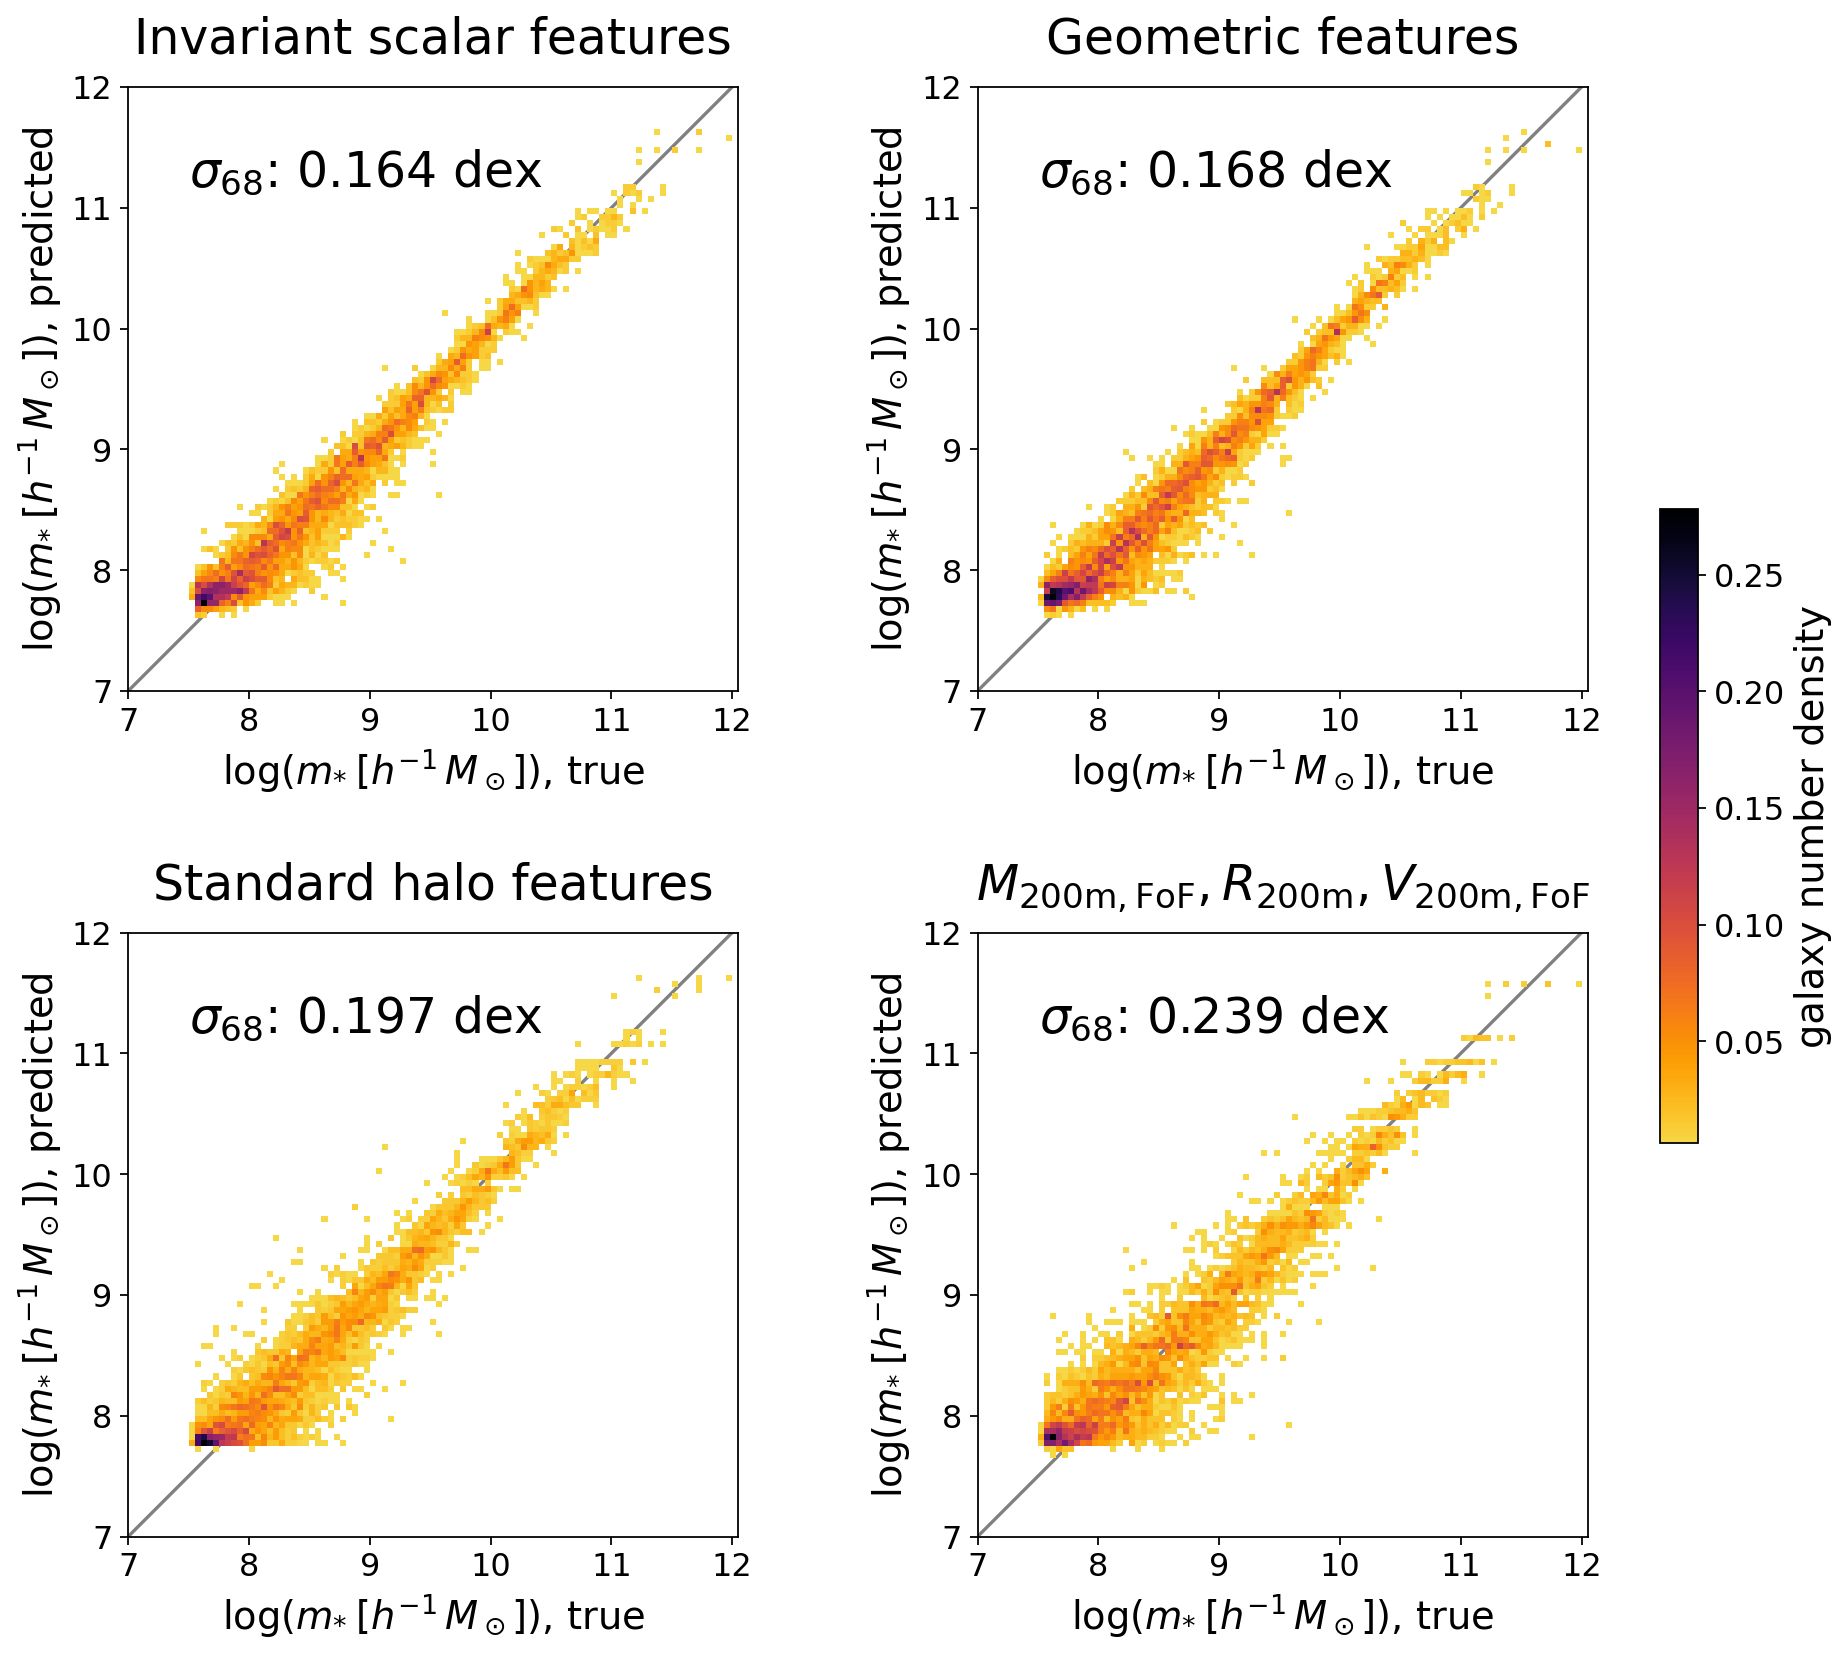

In [26]:
plot_multi_panel_pred_vs_true(2, 2, y_label_name, y_test, y_pred_arr, 
                             cmap_hist, text_results_arr=text_results_arr,
                            weight=weight, weight_by_dex=True, colorbar_label=colorbar_label,
                             title_arr=feature_labels)
fn = f'{plot_dir}/feature_comparison_mstellar.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

# Galaxy properties

In [27]:
mbh_zero = np.min(tab_halos['mbh'][tab_halos['mbh']!=0])/2.0  
print(mbh_zero)
print(np.log10(mbh_zero))

3.9999998989515007e-05
-4.397940019643239


In [28]:
np.min(tab_halos['log_mbh'])

5.60206

In [29]:
feature_modes = ['scalars_n3', 'geos_n3', 'catalogz0', 'mrv']
# #feature_modes = ['scalars', 'catalog_z0', 'mrv']
#feature_modes = ['scalars_n3']
# #feature_modes = ['catalog_z0']
feature_labels = [feature_label_dict[feature_mode] for feature_mode in feature_modes]

In [30]:
x_label_name = 'log_m200m_fof'
label_tag = 'galprops'
y_label_names = utils.get_gal_prop_names(label_tag)
y_label_name_plot = y_label_names
print(y_label_names)

['log_mstellar', 'log_ssfr1', 'log_rstellar', 'log_jstellar', 'gband_minus_iband', 'log_mbh_per_mstellar']


In [31]:
x_property = tab_halos_select[x_label_name][idx_test]
x_bins = np.arange(10.25, 13.7501, 0.5)
print(x_bins)

[10.25 10.75 11.25 11.75 12.25 12.75 13.25 13.75]


In [32]:
y_true_arr = []
y_pred_arr = []
text_results_arr = []

j_fiducial = feature_modes.index('scalars_n3')
#j_fiducial = feature_modes.index('catalog_z0')

y_true_arr_all = utils.load_labels(y_label_names,
                               tab_halos, tab_select)
y_true_arr = y_true_arr_all[idx_test].T

y_pred_feat_arr = []
for j in range(len(feature_modes)):
    feature_mode = feature_modes[j]
    fit_tag = f'_{feature_mode}_{label_tag}{model_tag}'

    fn_model = f'../models/model_{sim_name}{halo_tag}{fit_tag}.pt'
    fn_pred = f'../predictions/predictions_{sim_name}{halo_tag}{fit_tag}.npy'
    y_pred_all = np.load(fn_pred)
    y_pred_feat_arr.append(np.atleast_2d(y_pred_all))
    
y_pred_feat_arr = np.array(y_pred_feat_arr)
print(y_pred_feat_arr.shape)

y_lowerlim_arr = []    
for y_label_name in y_label_name_plot:
    i = y_label_names.index(y_label_name)
    y_test = y_true_arr[i]
    y_pred = y_pred_feat_arr[j_fiducial,:,i]
    y_pred_feats = y_pred_feat_arr[:,:,i]
    error_nn, _ = utils.compute_error(y_test, y_pred, test_error_type='percentile')
    error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
    
    # not passing halo_logmass_min bc shy made same cut as our fiducial
    _, stdevs_binned = utils.get_butterfly_error(x_bins, y_label_name,
                                                      #halo_logmass_min=select_params['select']['halo_logmass_min'], 
                                                      #n_bins=10
                                                     )
    y_lowerlim_arr.append(stdevs_binned)
    
    #y_true_arr.append(y_test)
    y_pred_arr.append(y_pred_feats)
    text_results_arr.append(error_str)

# x_bins_avg same for all, we'll just grab the last one
y_pred_arr = np.array(y_pred_arr)
print(y_pred_arr.shape)
print(x_property.shape)
print(y_true_arr.shape)

(4, 4712, 6)
[10.25 10.75 11.25 11.75 12.25 12.75 13.25 13.75]
[0.12963028977253044, 0.09972087593920888, 0.05248953710332294, 0.0430367630863823, 0.043999504072024624, 0.03538427239748146, 0.0243258764441859]
[10.25 10.75 11.25 11.75 12.25 12.75 13.25 13.75]
[0.34671905079360615, 0.25804214338626474, 0.2639468473790663, 0.6605295359515669, 0.45579333498717894, 0.350531130064047, 0.4742970970556796]
[10.25 10.75 11.25 11.75 12.25 12.75 13.25 13.75]
[0.07537020820539224, 0.09319289659441299, 0.09330745661787782, 0.07031006623521024, 0.062023530593352874, 0.10389926003635994, 0.031254813966224954]
[10.25 10.75 11.25 11.75 12.25 12.75 13.25 13.75]
[nan, nan, 0.1829557002453577, 0.13949257479140395, 0.14909356609714772, 0.13359560014952307, 0.11573754394790534]
[10.25 10.75 11.25 11.75 12.25 12.75 13.25 13.75]
[0.18541556695650352, 0.1575222354898453, 0.12017155133224211, 0.11187672790237581, 0.0326087526858771, 0.06396773329400339, 0.10176978157930838]
[10.25 10.75 11.25 11.75 12.25 12.75

In [33]:
frac_test = len(idx_test)/len(tab_select)
L_Mpc = sim_reader.box_size / 1000.0
weight = 1/(L_Mpc**3 * frac_test)
colorbar_label = 'galaxy number density\n'+r'[$h^{-1}$ Mpc)$^{-3}$ dex$^{-2}$]'

In [34]:
colors = ['black', 'maroon', 'lightseagreen', 'forestgreen']

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:285: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


../plots/2023-05-04_figures/pred_galprops.png


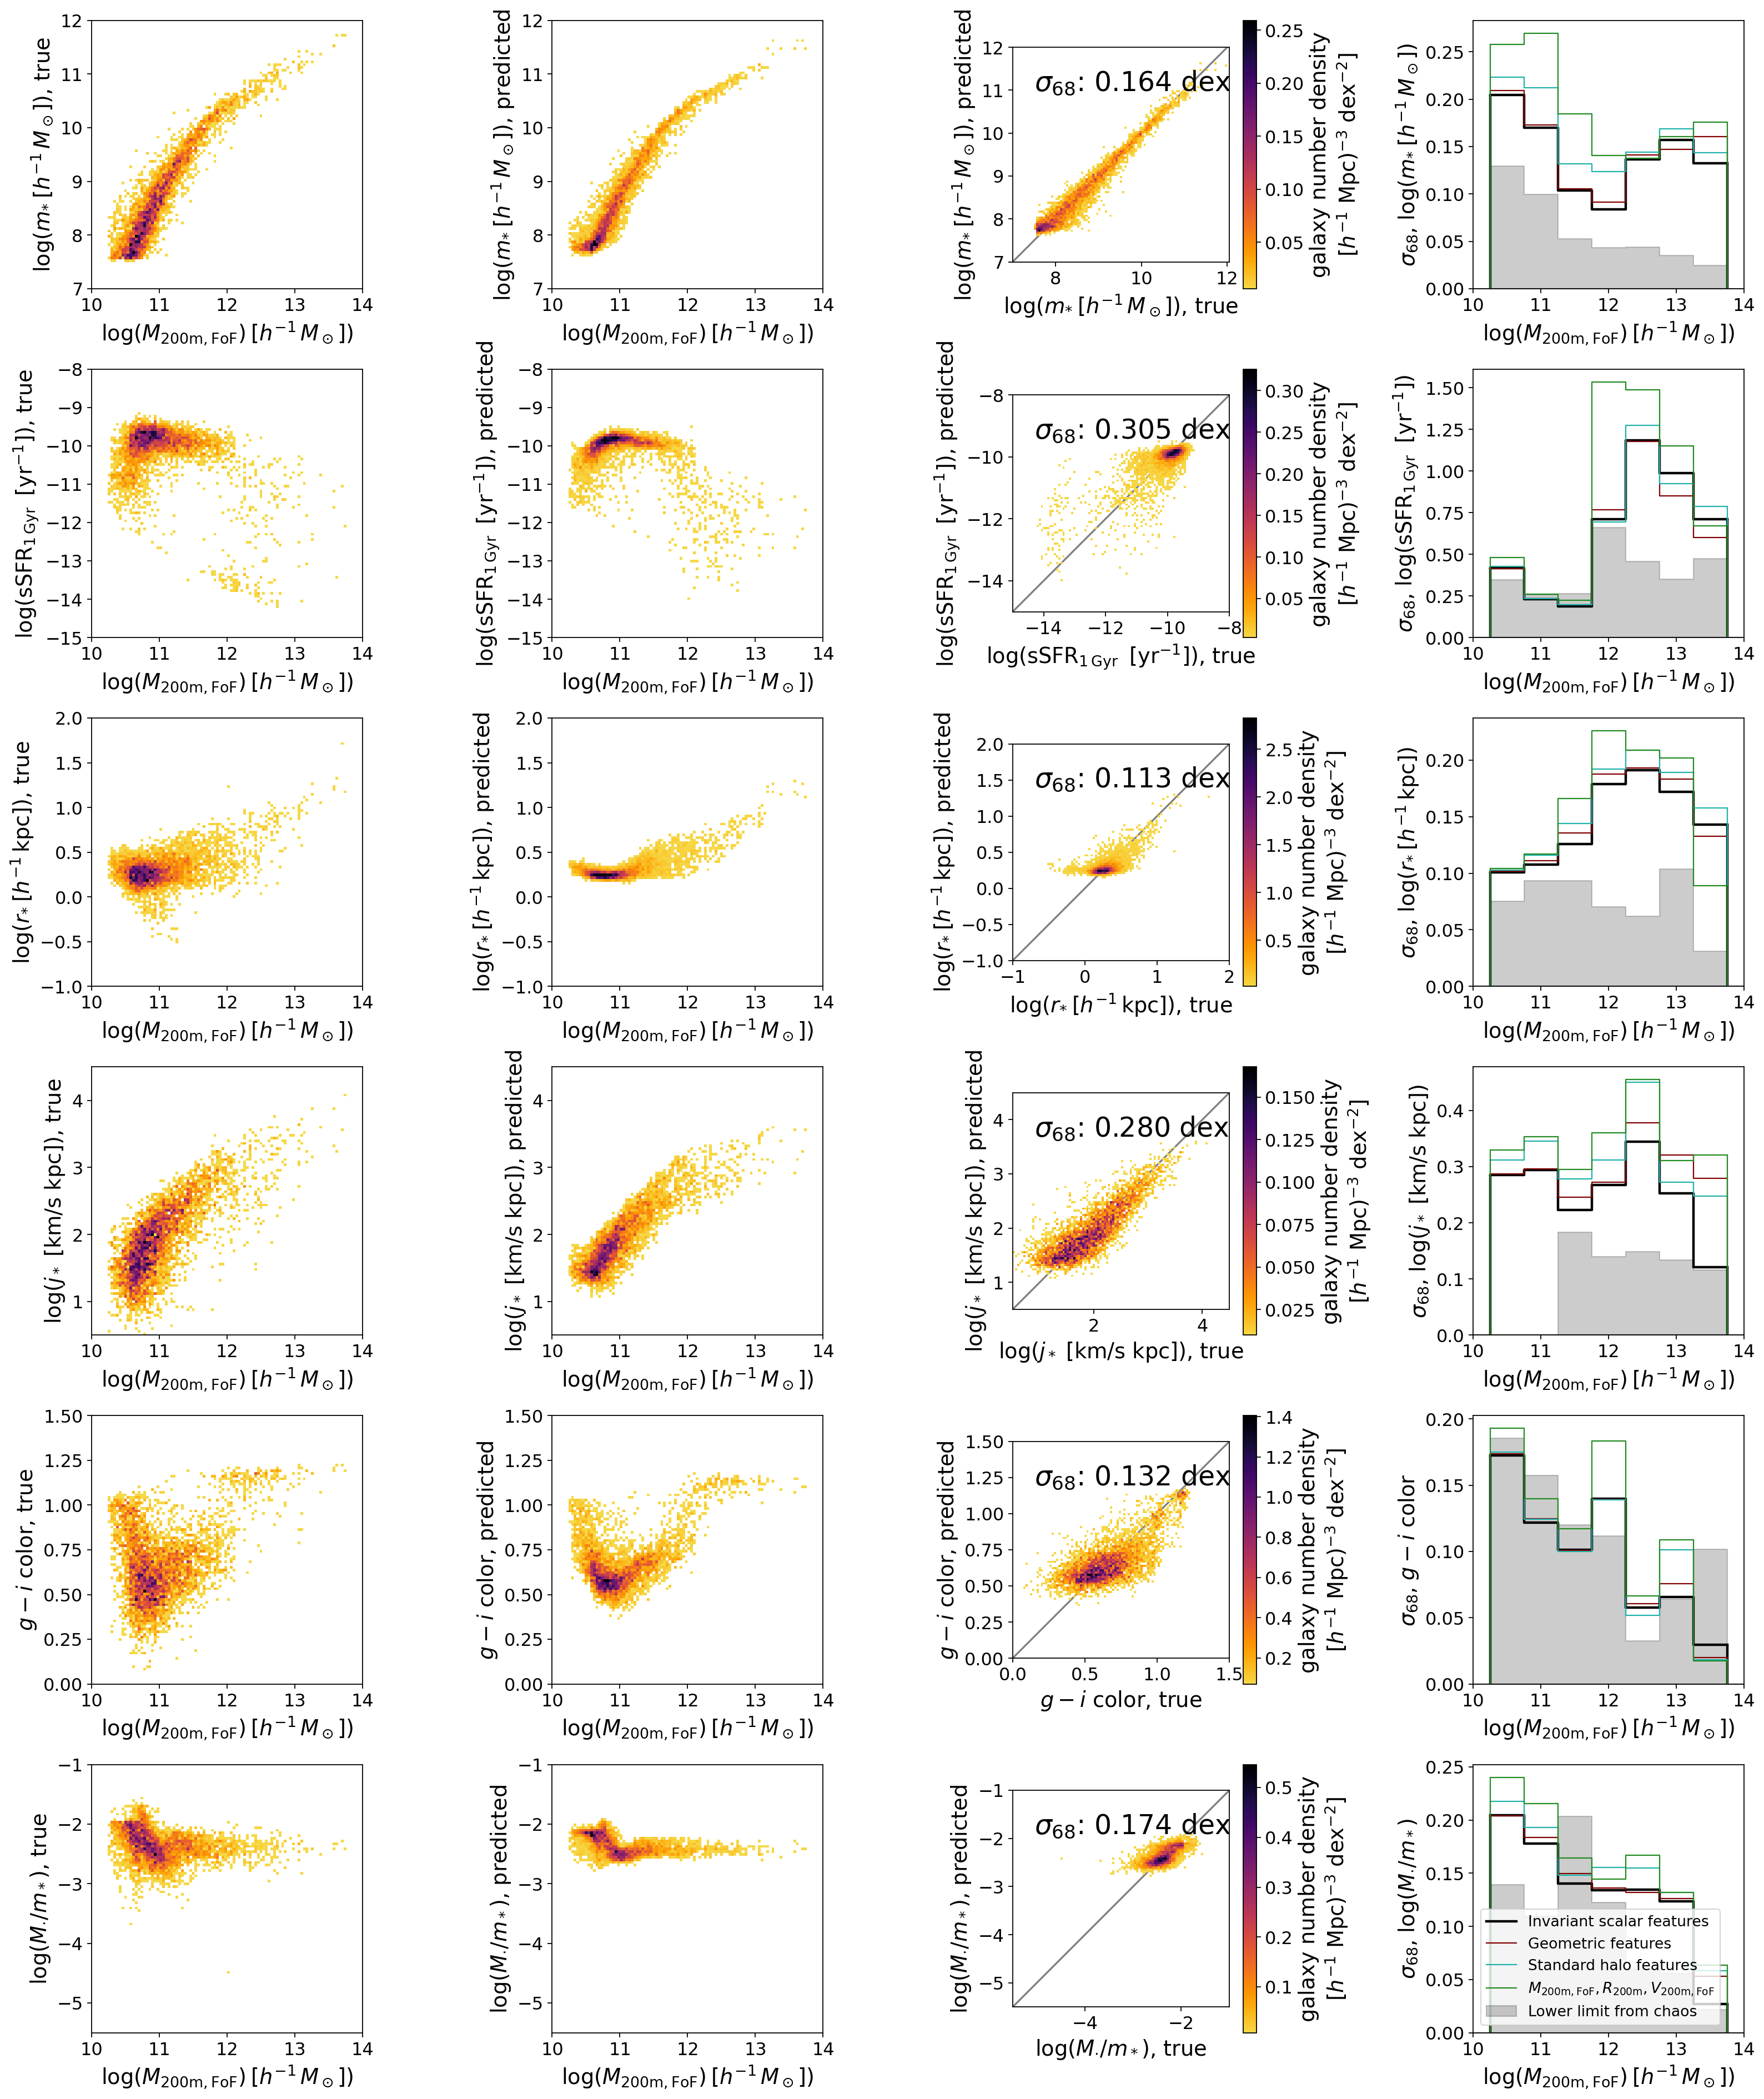

In [35]:
plotter.plot_multi_panel_gal_props_errors(x_label_name, y_label_name_plot, x_property, y_true_arr, y_pred_arr,
                                   feature_labels, colors,
                                   j_fiducial=j_fiducial,
                                   weight=weight, weight_by_dex=True, colorbar_label=colorbar_label,
                                   text_results_arr=text_results_arr,
                                   x_bins=x_bins, y_lowerlim_arr=y_lowerlim_arr)
fn = f'{plot_dir}/pred_{label_tag}.png'
if save:
    print(fn)
    plt.savefig(fn, bbox_inches='tight')

# histograms

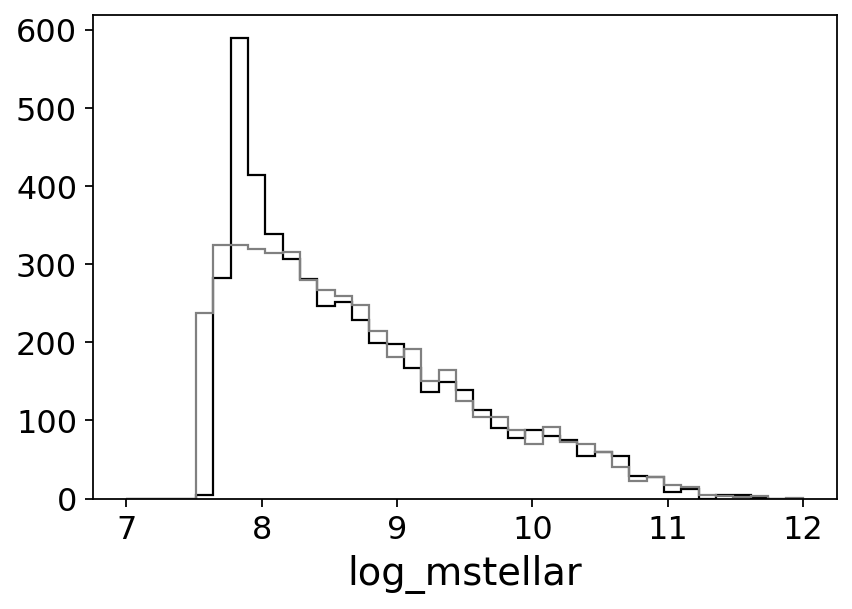

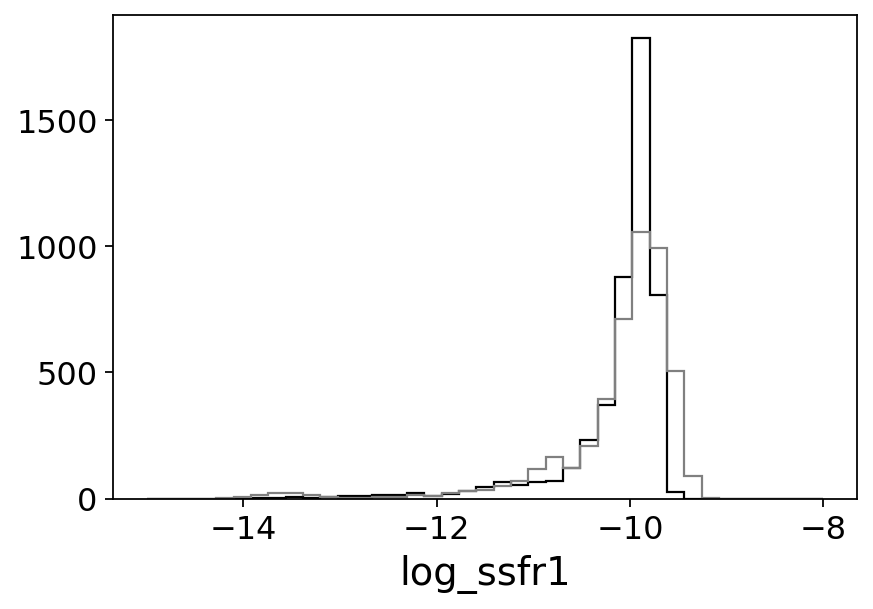

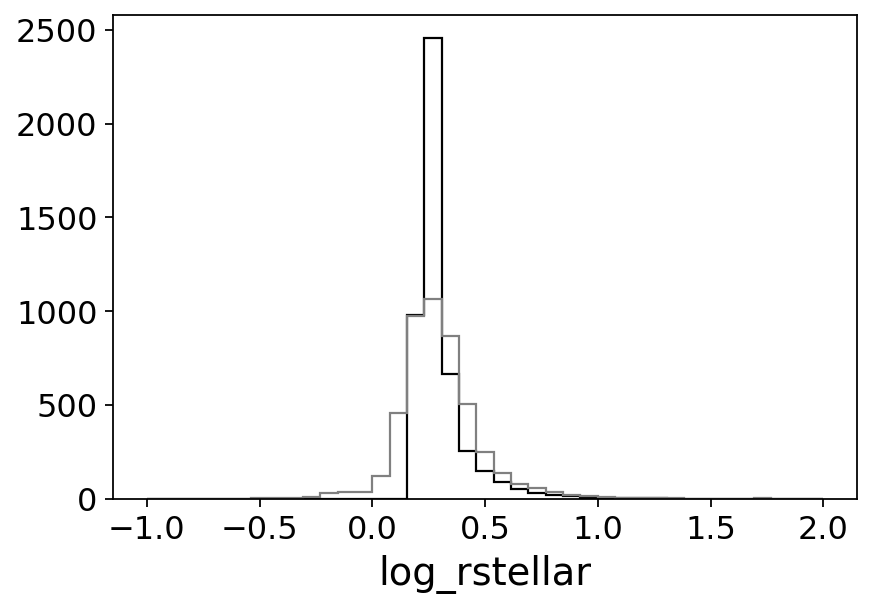

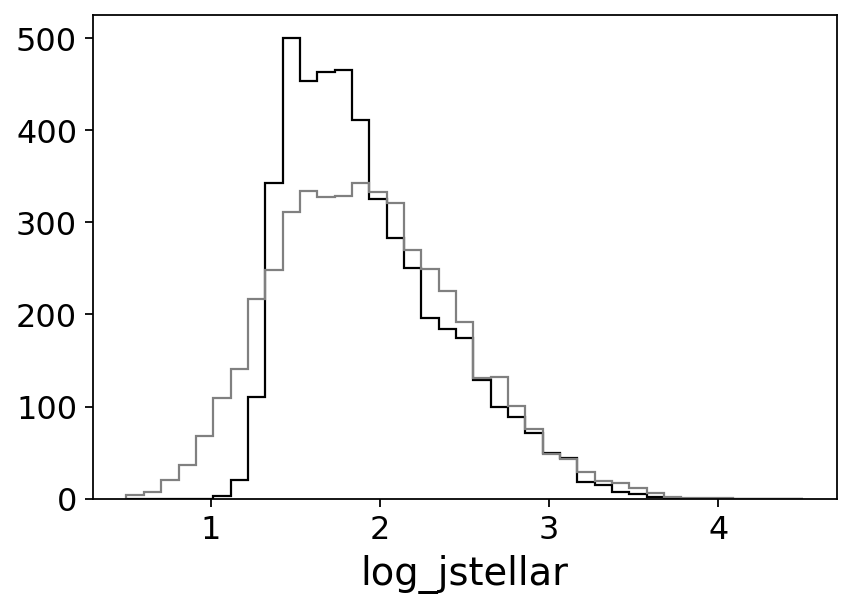

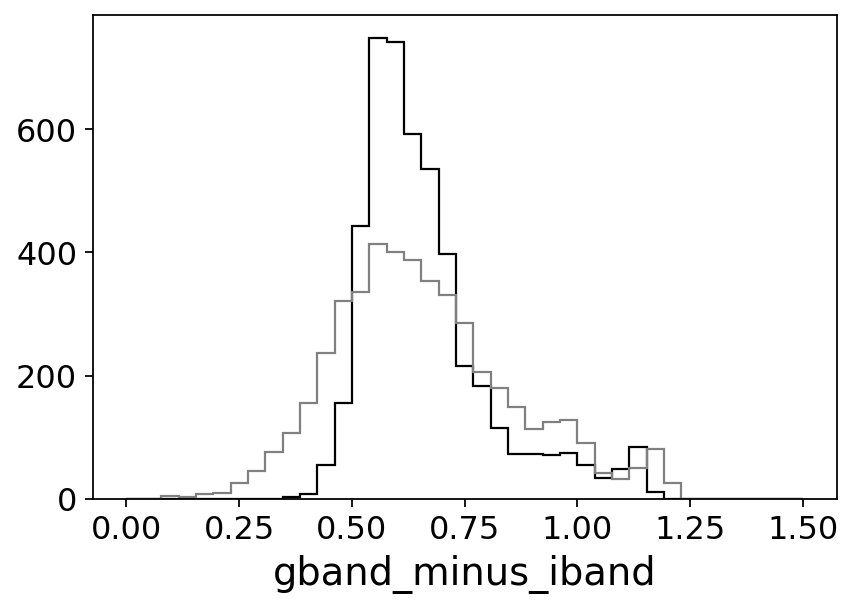

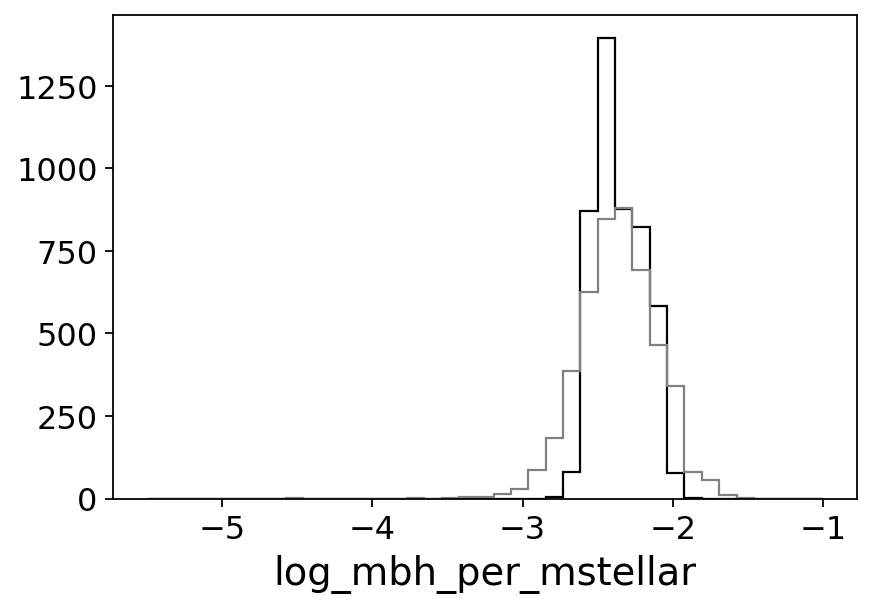

In [36]:
for y_label_name in y_label_name_plot:
    i = y_label_names.index(y_label_name)
    y_test = y_true_arr[i]
    y_pred = y_pred_feat_arr[j_fiducial,:,i]
    y_pred_feats = y_pred_feat_arr[:,:,i]
    plt.figure()
    bins = np.linspace(*utils.lim_dict[y_label_name], 40)
    plt.hist(y_pred, bins=bins, histtype='step', color='black')
    plt.hist(y_test, bins=bins, histtype='step', color='grey')
    plt.xlabel(y_label_name)

# Mass Assembly History

### multi-panel plot

In [49]:
y_label_name = 'amfracs'
feature_mode = 'mrv'
fit_tag = f'_{feature_mode}_{y_label_name}{model_tag}'
#fn_amfrac = f'../data/mahs/amfracs_{sim_name}{halo_tag}.fits'
#fn_model = f'../models/model_{sim_name}{halo_tag}{fit_tag}.pt'
#fn_pred = f'../predictions/predictions_{sim_name}{halo_tag}{fit_tag}.npy'
fn_amfrac = f'../data/mahs/amfracs_{sim_name}_mini10.fits'
fn_model = f'../models/model_{sim_name}_mini10{fit_tag}.pt'
fn_pred = f'../predictions/predictions_{sim_name}_mini10{fit_tag}.npy'

In [50]:
y_pred = np.load(fn_pred)
print(y_pred.shape)

(1, 39)


In [51]:
y = utils.load_labels(y_label_name, tab_halos, tab_select, fn_amfrac=fn_amfrac)
y_test = y[idx_test]

(10, 39)
(10, 39)
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/ext3/miniconda3/envs/eqenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/state/partition1/job-32998701/ipykernel_3722338/3222813463.py", line 1, in <cell line: 1>
    y = utils.load_labels(y_label_name, tab_halos, tab_select, fn_amfrac=fn_amfrac)
  File "/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py", line 764, in load_labels
    return labels[idxs_table]
IndexError: index 10 is out of bounds for axis 0 with size 10

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/ext3/miniconda3/envs/eqenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 1993, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/ext3/miniconda3/envs/eqenv/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1118, in structured_traceback
    retur

In [ ]:
tab_amfrac = load_table(fn_amfrac)
mfrac_vals = [float(c) for c in tab_amfrac.column_names]

In [ ]:
# n = y_label_name.split('_n')[-1]
# mfrac_vals = utils.get_mfrac_vals(int(n)) # should include 1 or no? now does

In [ ]:
plotter.plot_a_mfrac_accuracy(y_pred, y_test, mfrac_vals, title='', n_show=8)